/Users/nickvazz/Desktop/virtualenvs/3MLenv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/nickvazz/Desktop/virtualenvs/3MLenv/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


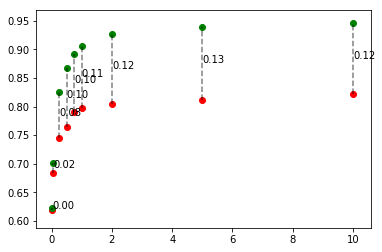

('arizonans', 4.560170771703952)
('keep', 3.967180883085389)
('move', 3.9371742800610283)
('hampshire', 3.3655846525029016)
('hispanic', 3.2695014155842164)
('obamacare', 3.234926653154982)
('young', 3.2127229073386214)
('ct', 3.2016865473296137)
('right', 3.1972895642009713)
('mississippi', 3.15287688730857)
----------
('progress', -5.997967275863121)
('ic', -4.990274660072231)
('blue', -4.687610546466059)
('environment', -4.401601988537372)
('trivedi', -4.276922058781615)
('bucket', -4.0609515926608895)
('rural', -3.7721783529670465)
('iowans', -3.771255146451933)
('nurses', -3.764031663665675)
('student', -3.7378402720274453)


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import numpy as np

# https://www.opensecrets.org/pacs/superpacs.php?cycle=2014

jointFund = !ls PoliticalFinancialData/J*
superPacs = !ls PoliticalFinancialData/S*

df_s = []
for s in superPacs:
    year = s.split('-')[-1].replace('.xlsx','')
    df = pd.read_excel(s)
    df['year'] = year
    df_s.append(df)
    
df_j = []
for j in jointFund:
    year = j.split('-')[-1].replace('.xlsx','')
    df = pd.read_excel(j)
    df['year'] = year
    df_j.append(df)
    
df_s = pd.concat(df_s)
df_j = pd.concat(df_j)

df_s = df_s.loc[df_s['Viewpoint'].isin(['Conservative','Liberal'])]
df_j = df_j.loc[df_j['Party'].isin(['R','D'])]

df_s = df_s.reset_index().dropna(subset=['Viewpoint'])
df_j = df_j.reset_index().dropna(subset=['Party'])

df_s.replace({'Conservative':'R', 'Liberal':'D'}, inplace=True)

df_s = df_s.drop('index', axis=1)
df_j = df_j.drop('index', axis=1)

replace_punc = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")

names = df_s['Group']
names.append(df_j['Committee'])
names = names.apply(lambda x: x.lower())
names = names.apply(lambda x: replace_punc.sub("", x))

terms_to_replace = [
    'conservative',
    'conservatives',
    'republican',
    'republicans',
    'progressive',
    'democrat',
    'democrats'
    'democratic',
]

for term in terms_to_replace:
    names = names.apply(lambda x: x.replace(term, ''))
    
cv = CountVectorizer(binary=True)
cv.fit(names)

X = cv.transform(names)

stance = df_s['Viewpoint']
stance.append(df_j['Party'])

y = label_binarize(stance.values, classes=['D','R'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

Cs = [0.01, 0.05, 0.25, 0.5, 0.75, 1.0, 2.0, 5.0, 10.0]
for c in Cs:
    clf = LogisticRegression(C=c)
#     clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    
    
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    plt.scatter(c, test_acc, color='r')
    plt.scatter(c, train_acc, color='g')
    plt.plot((c, c), (test_acc, train_acc), linestyle='--', alpha=0.5, color='k')
    plt.text(c, test_acc + (train_acc - test_acc) / 2, '{:.2f}'.format(train_acc - test_acc))
plt.show()



feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), clf.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:10]:
    print (best_positive)
    
print ('-'*10)
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:10]:
    print (best_negative)

In [29]:
from itertools import chain
best = sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]
worst = sorted(feature_to_coef.items(), key=lambda x: x[1])[:10]
data = chain(best, worst)

# data = sorted(feature_to_coef.items(), key=lambda x: x[1])

df = pd.DataFrame(list(data), columns=['words','score'])

x = df.loc[:, ['score']]
df['word_z'] = (x - x.mean())/x.std()
df['colors'] = ['blue' if x < 0 else 'red' for x in df['word_z']]
df.sort_values('score', inplace=True)
df.reset_index(inplace=True)

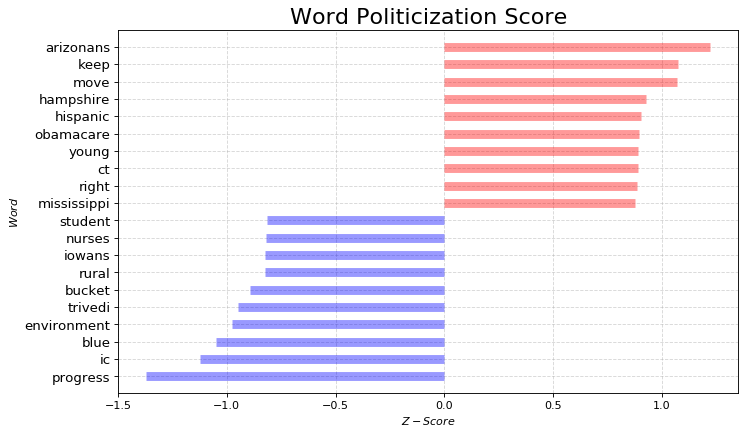

In [34]:
# Draw plot
plt.figure(figsize=(10,6), dpi= 80)
plt.hlines(y=df.words, xmin=0, xmax=df.word_z, color=df.colors, alpha=0.4, linewidth=8)

# Decorations
plt.gca().set(ylabel='$Word$', xlabel='$Z-Score$')
plt.yticks(df.words, df.words, fontsize=12)
plt.title('Word Politicization Score', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()